# Node

In [ ]:
from copy import deepcopy
from graphviz import Digraph
import heapq
import numpy as np
import random


class Node:

  def __init__(self, state, action = None, parent = None):
    self.state = state # 2D list (3x3)
    self.id = str(self) # identifier of node
    self.action = action
    self.parent = parent

  def __eq__(self, other):
        return (self.state == other.state)

  def __ne__(self, other):
        return not (self == other)

  def __lt__(self, other):
        return (self.state < other.state)

  def __gt__(self, other):
        return (self.state > other.state)

  def __le__(self, other):
        return (self < other) or (self == other)

  def __ge__(self, other):
        return (self > other) or (self == other)

  def __str__(self):
    result = ""
    for row in self.state:
        for cell in row:
            result += str(cell) if cell != 0 else '_'
        result += '\n'

    return result.rstrip('\n')

  def get_successors(self):
    successors = []
    actions = ['Left', 'Right', 'Up', 'Down']

    for action in actions:
        successor_state = self.get_successor(action, deepcopy(self.state))
        if successor_state is not None:
            successors.append(Node(successor_state, action, self))

    return successors

  def get_successor(self, action, state):
    pi, pj = self.get_blank_pos(state)
    pi, pj = self.get_dest_pos(action, pi, pj)

    if 0 <= pi and pi < 3 and 0 <= pj and pj < 3:
      if action == 'Left':
        state[pi][pj - 1] = state[pi][pj]
      if action == 'Right':
        state[pi][pj + 1] = state[pi][pj]
      if action == 'Up':
        state[pi-1][pj] = state[pi][pj]
      if action == 'Down':
        state[pi+1][pj] = state[pi][pj]
      state[pi][pj] = 0
      return state

    return None

  def get_dest_pos(self, action, pi, pj):
    if action == 'Left':
      pj += 1
    if action == 'Right':
      pj -= 1
    if action == 'Up':
      pi += 1
    if action == 'Down':
      pi -= 1
    return pi, pj

  def get_blank_pos(self, state):
    for i in range(3):
        for j in range(3):
            if state[i][j] == 0:
                return i, j

  def equal(self, a, b):
    for i in range(3):
        for j in range(3):
          if a.state[i][j] != b.state[i][j]:
            return False
    return True

  def get_id(self):
    return self.id

  def get_node_str(self):
    return str(self)

  def get_action(self):
    return self.action

  def get_state(self):
    return self.state

# Search Strategy Class

In [ ]:
class Search:

    def find_path(self, goal_node):
        path = []
        current_node = goal_node
        while current_node:
            path.insert(0, current_node)
            current_node = current_node.parent
        return path

    def find_action(self, goal_node):
        path = []
        current_node = goal_node
        while current_node.parent:
            path.insert(0, current_node.get_action())
            current_node = current_node.parent
        return path

    def draw(self, solution_path):
        dot = Digraph()
        for node in solution_path:
          dot.node(node.get_id(), node.get_node_str())
          if node.parent is not None:
            dot.edge(node.parent.get_id(), node.get_id(), node.get_action())
        return dot


# BFS

In [ ]:
class EightPuzzleSolverBFS(Search):

    def __init__(self, initial_state, goal_test):
        self.initial_node = Node(initial_state)
        self.goal_test = Node(goal_test)

    def solve(self):
        frontier = [self.initial_node]
        explored = set()

        while frontier:
            current_node = frontier.pop(0)
            explored.add(current_node.get_id())

            if current_node.get_state() == self.goal_test.get_state()[0] or current_node.get_state() == self.goal_test.get_state()[1]:
                return super().find_path(current_node), super().find_action(current_node), len(explored), len(frontier)

            successors = current_node.get_successors()
            for successor in successors:
                if successor.get_id() not in explored and successor.get_id():
                    frontier.append(successor)


        return None, None, len(explored), len(frontier)

    def draw(self, solution_path):
      return super().draw(solution_path)


# AStar and Heuristic


In [ ]:
class EightPuzzleSolverA(Search):
    def __init__(self, initial_state, goal_test):
        self.initial_node = Node(initial_state)
        self.goal_test = Node(goal_test)

    #H1: Number of misplaced tiles
    def heuristic_h1(self, initial_node):
        number_of_misplaced_tiles = 0
        for i in range(len(initial_node.get_state())):
          for j in range(len(initial_node.get_state()[0])):
            if initial_node.get_state()[i][j] != self.goal_test.get_state()[i][j]:
              number_of_misplaced_tiles += 1
        return number_of_misplaced_tiles

    #H2: Sum of Eucledian distances of the tiles from their goal positions
    def heuristic_h2(self, initial_node):
        sum_eucledian = 0
        current_state_mappings = {}
        goal_state_mappings = {}
        for i in range(len(initial_node.get_state())):
          for j in range(len(initial_node.get_state()[0])):
            current_state_tile = initial_node.get_state()[i][j]
            goal_state_tile = self.goal_test.get_state()[i][j]
            if current_state_tile != 0:
                indices = (i, j)
                current_state_mappings[current_state_tile] = indices
            if goal_state_tile != 0:
                indices = (i, j)
                goal_state_mappings[goal_state_tile] = indices
        for tile, indices in current_state_mappings.items():
            goal_indices = goal_state_mappings.get(tile)
            if goal_indices:
                distance = ((indices[0] - goal_indices[0]) ** 2 + (indices[1] - goal_indices[1]) ** 2) ** 0.5
                sum_eucledian += distance

        return sum_eucledian

    #H3: Sum of Manhattan distances of the tiles from their goal positions
    def heuristic_h3(self, initial_node):
        sum_manhattan = 0
        current_state_mappings = {}
        goal_state_mappings = {}
        for i in range(len(initial_node.get_state())):
          for j in range(len(initial_node.get_state()[0])):
            current_state_tile = initial_node.get_state()[i][j]
            goal_state_tile = self.goal_test.get_state()[i][j]
            if current_state_tile != 0:
                indices = (i, j)
                current_state_mappings[current_state_tile] = indices
            if goal_state_tile != 0:
                indices = (i, j)
                goal_state_mappings[goal_state_tile] = indices
        for tile, indices in current_state_mappings.items():
            goal_indices = goal_state_mappings.get(tile)
            if goal_indices:
                distance = abs(indices[0] - goal_indices[0]) + abs(indices[1] - goal_indices[1])
                sum_manhattan += distance
        return sum_manhattan

    #H4:  Number of tiles out of row + Number of tiles out of column
    def heuristic_h4(self, current_state):
        sum_row = 0
        sum_colum = 0
        current_state_mappings = {}
        goal_state_mappings = {}
        goal_state_transpose = np.transpose(self.goal_test.get_state())
        for i in range(len(current_state.get_state())):
            for j in range(len(current_state.get_state()[0])):
                goal_state_row = self.goal_test.get_state()[i]
                if current_state.get_state()[i][j] not in goal_state_row and current_state.get_state()[i][j] != 0:
                    sum_row += 1
                goal_state_colum = goal_state_transpose[i]
                if current_state.get_state()[j][i] not in goal_state_colum and current_state.get_state()[j][i] != 0:
                    sum_colum += 1

        return sum_row + sum_colum

    def solve(self, h):
        explored = set()
        dic_cost = [(h(self.initial_node), 0, self.initial_node)]
        frontier = [self.initial_node]
        depth_tree = 0
        cost_path = 0
        depth_tree_use = 0

        while(dic_cost):
            cost_node, depth_of_tree, current_node = heapq.heappop(dic_cost)
            if depth_of_tree < depth_tree:
                depth_tree_use = depth_of_tree + 1
            else:
                depth_tree += 1
                depth_tree_use = depth_tree
            explored.add(current_node.get_id())

            if current_node.get_state() == self.goal_test.get_state():
                return super().find_path(current_node), super().find_action(current_node), len(explored), len(dic_cost)
            successors = current_node.get_successors()

            for i in successors:
                value_heuristic = h(i)
                cost = value_heuristic + depth_tree_use
                if i not in frontier and i.get_id() not in explored:
                    heapq.heappush(dic_cost, (cost, depth_tree_use, i))
                    frontier.append(i)

        return None, None, len(explored), len(dic_cost)

    def draw(self, solution_path):
        return super().draw(solution_path)



# Visualize

Initial state: 182403765
Search strategy (bfs, astar): astar
Heuristic (h1, h2, h3, h4): h1


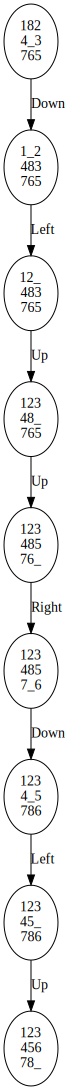

In [ ]:
def strTo8Puzzle(str: str) -> list:
    initial_state = [[int(i) for i in str[0:3]], [int(i) for i in str[3:6]], [int(i) for i in str[6:]]]
    return initial_state


def get8PuzzleInput():
    initial_state_str = input('Initial state: ')
    while len(initial_state_str) != 9:
        initial_state_str = input('Initial state: ')
    search_strategy = input('Search strategy (bfs, astar): ').lower()

    initial_state = strTo8Puzzle(initial_state_str)

    return initial_state, search_strategy


initial_state, search_strategy = get8PuzzleInput()
if search_strategy == 'bfs':
    goal_test = [[[1,2,3],
            [4,5,6],
            [7,8,0]], [[0,1,2],
                       [3,4,5],
                       [6,7,8]]]
    solver = EightPuzzleSolverBFS(initial_state, goal_test)
    solution_path, solution_action, explored, frontier = solver.solve()
    draw = solver.draw(solution_path)
else:
    goal_test = [[1,2,3],
            [4,5,6],
            [7,8,0]]
    heuristic = input('Heuristic (h1, h2, h3, h4): ').lower()
    solver = EightPuzzleSolverA(initial_state, goal_test)
    h = {
        'h1': solver.heuristic_h1,
        'h2': solver.heuristic_h2,
        'h3': solver.heuristic_h3,
        'h4': solver.heuristic_h4
    }
    solution_path1, solution_action1, explored1, frontier1 = solver.solve(h[heuristic])
    draw = solver.draw(solution_path1)
draw





In [ ]:
initial_state = [[1, 8, 2],
          [4, 0, 3],
          [7 ,6, 5]]

goal_test = [[1,2,3],
            [4,5,6],
            [7,8,0]]

solver = EightPuzzleSolverA(initial_state, goal_test)
h1 = solver.heuristic_h1
h2 = solver.heuristic_h2
h3 = solver.heuristic_h3
h4 = solver.heuristic_h4
solution_path1, solution_action1, explored1, frontier1 = solver.solve(h1)
solution_path2, solution_action2, explored2, frontier2 = solver.solve(h2)
solution_path3, solution_action3, explored3, frontier3 = solver.solve(h3)
solution_path4, solution_action4, explored4, frontier4 = solver.solve(h4)

In [ ]:
a1 = solver.draw(solution_path1)
a1

In [ ]:
a2 = solver.draw(solution_path2)
a2

In [ ]:
a3 = solver.draw(solution_path3)
a3

In [ ]:
a4 = solver.draw(solution_path4)
a4

In [ ]:
initial_state = [[1, 8, 2],
          [4, 0, 3],
          [7 ,6, 5]]
goal_test = [[[1,2,3],
            [4,5,6],
            [7,8,0]], [[0,1,2],
                       [3,4,5],
                       [6,7,8]]]
solver = EightPuzzleSolverBFS(initial_state, goal_test)
solution_path, solution_action, explored, frontier = solver.solve()
print("Số node expand: ",explored)
print("Số node trong frontier: ",frontier)
print("Danh sách action: ", len(solution_action))

if solution_path:
    a = solver.draw(solution_path)
else:
    print("No solution found.")



Số node expand:  316
Số node trong frontier:  213
Danh sách action:  8


In [ ]:
import time
#random_state
initial_state = [[1, 8, 2],
          [4, 0, 3],
          [7, 6, 5]]
node = Node(initial_state)

frontier = [node]
random_state = [initial_state]

while len(random_state) < 1000:
    node = frontier.pop(0)
    for successor in node.get_successors():
        if successor.state not in random_state and len(random_state) != 1000:
            random_state.append(successor.state)
            frontier.append(successor)

In [ ]:
#bfs
goal_test = [[[1,2,3],
            [4,5,6],
            [7,8,0]], [[0,1,2],
                       [3,4,5],
                       [6,7,8]]]
len_explored = 0
len_frontier = 0
cost = 0
time_start = time.time()
for state in random_state:
    solver = EightPuzzleSolverBFS(state, goal_test)
    _, solution_action, explored, frontier = solver.solve()
    len_explored += explored
    len_frontier += frontier
    cost += len(solution_action)
time_end = time.time()
print(time_end - time_start)

In [ ]:
goal_test = [[1,2,3],
            [4,5,6],
            [7,8,0]]

solver = EightPuzzleSolverA(initial_state, goal_test)
h1 = solver.heuristic_h1
h2 = solver.heuristic_h2
h3 = solver.heuristic_h3
h4 = solver.heuristic_h4
len_cost1 = 0
len_cost2 = 0
len_cost3 = 0
len_cost4 = 0
len_explored1 = 0
len_explored2 = 0
len_explored3 = 0
len_explored4 = 0
len_frontier1 = 0
len_frontier2 = 0
len_frontier3 = 0
len_frontier4 = 0
time_s = time.time()
for state in random_state:
    solver = EightPuzzleSolverA(initial_state, goal_test)
    solution_path1, solution_action1, explored1, frontier1 = solver.solve(h1)
    len_cost1 += len(solution_action1)
    len_explored1 += explored1
    len_frontier1 += frontier1
time_e = time.time()
print(time_e - time_s)



In [ ]:
time_s = time.time()
for state in random_state:
    solver = EightPuzzleSolverA(initial_state, goal_test)
    solution_path2, solution_action2, explored2, frontier2 = solver.solve(h2)
    len_cost2 += len(solution_action2)
    len_explored2 += explored2
    len_frontier2 += frontier2
time_e = time.time()
print(time_e - time_s)

In [ ]:
time_s = time.time()
for state in random_state:
    solver = EightPuzzleSolverA(initial_state, goal_test)
    solution_path3, solution_action3, explored3, frontier3 = solver.solve(h3)
    len_cost3 += len(solution_action3)
    len_explored3 += explored3
    len_frontier3 += frontier3
time_e = time.time()
print(time_e - time_s)

In [ ]:
time_s = time.time()
for state in random_state:
    solver = EightPuzzleSolverA(initial_state, goal_test)
    solution_path4, solution_action4, explored4, frontier4 = solver.solve(h4)
    len_cost4 += len(solution_action4)
    len_explored4 += explored4
    len_frontier4 += frontier4
time_e = time.time()
print(time_e - time_s)

In [ ]:
print(len_cost1, len_explored1, len_frontier1)
print(len_cost2, len_explored2, len_frontier2)
print(len_cost3, len_explored3, len_frontier3)
print(len_cost4, len_explored4, len_frontier4)